In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import statsmodels.api as sm
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

ticker_symbol = "RELIANCE.NS"
start_date = "2016-03-01"
end_date = "2021-02-26"
window_size = 10
batch_size = 72
epochs = 50
learning_rate = 0.001


In [2]:
data = yf.download(ticker_symbol, start=start_date, end=end_date)
print("Data shape:", data.shape)
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data shape: (1232, 5)


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2016-03-01,206.030518,206.817861,202.534740,202.545237,16453192
2016-03-02,210.271637,211.163956,207.279755,208.466005,20105967
2016-03-03,212.654648,213.735922,209.431806,212.056260,15880459
2016-03-04,211.300430,213.106063,210.691559,212.896098,8987660
2016-03-08,215.625519,216.444341,211.531354,211.531354,13222993


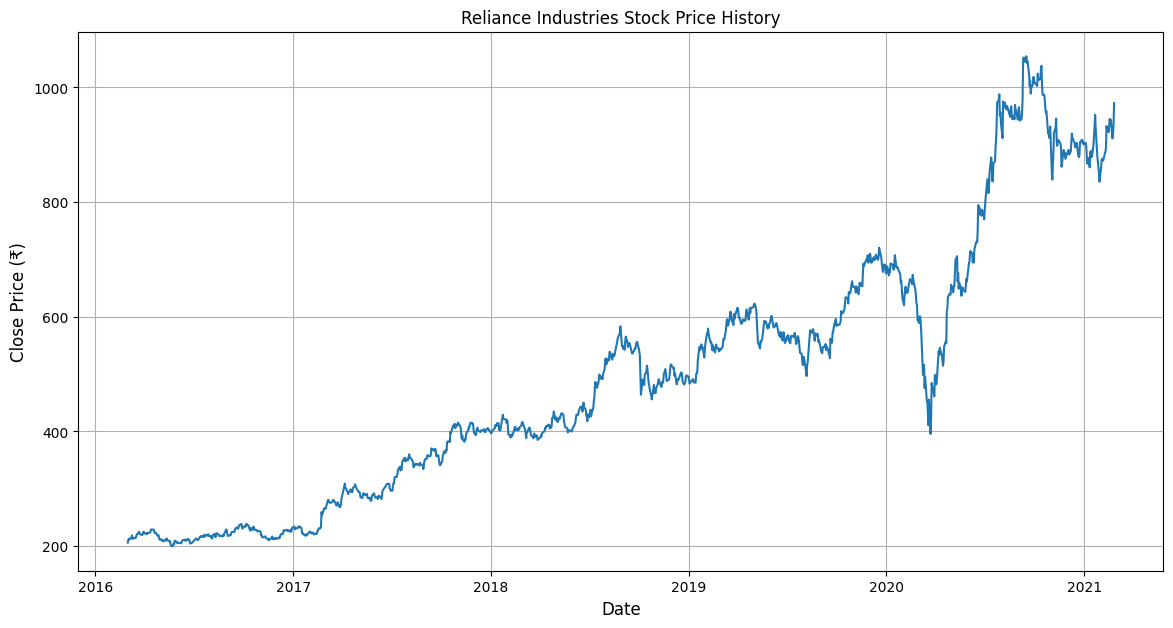

In [3]:
plt.figure(figsize=(14, 7))
plt.title('Reliance Industries Stock Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (₹)', fontsize=12)
plt.grid(True)
plt.show()

In [4]:

close_prices = data['Close'].values.reshape(-1, 1)


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

X = []
y = []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)


X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: X: {X_train.shape}, y: {y_train.shape}")
print(f"Testing data shape: X: {X_test.shape}, y: {y_test.shape}")


Training data shape: X: (977, 10, 1), y: (977,)
Testing data shape: X: (245, 10, 1), y: (245,)


In [5]:

def create_and_train_model(model_type, X_train, y_train, X_test, y_test, epochs=50, batch_size=72):
    if model_type == 'LSTM_Bidirectional':
        model = Sequential([
            Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], 1)),
            Dropout(0.2),
            Bidirectional(LSTM(50)),
            Dropout(0.2),
            Dense(1)
        ])
    elif model_type == 'GRU':
        model = Sequential([
            GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
            Dropout(0.2),
            GRU(50),
            Dropout(0.2),
            Dense(1)
        ])
    elif model_type == 'CNN':
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Conv1D(filters=32, kernel_size=3, activation='relu'),
            Flatten(),
            Dense(50, activation='relu'),
            Dense(1)
        ])
    elif model_type == 'LSTM_CNN':
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
            LSTM(50, return_sequences=True),
            Dropout(0.2),
            LSTM(50),
            Dense(1)
        ])
    elif model_type == 'GRU_CNN':
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
            GRU(50, return_sequences=True),
            Dropout(0.2),
            GRU(50),
            Dense(1)
        ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1
    )

    return model, history


In [6]:

models = {}
histories = {}

model_types = ['LSTM_Bidirectional', 'GRU', 'CNN', 'LSTM_CNN', 'GRU_CNN']

for model_type in model_types:
    print(f"\nTraining {model_type} model...")
    model, history = create_and_train_model(model_type, X_train, y_train, X_test, y_test, epochs, batch_size)
    models[model_type] = model
    histories[model_type] = history




Training LSTM_Bidirectional model...
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.0471 - val_loss: 0.0089
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 7.8202e-04 - val_loss: 0.0021
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 8.7975e-04 - val_loss: 0.0021
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 9.2719e-04 - val_loss: 0.0022
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 8.7369e-04 - val_loss: 0.0021
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 8.8327e-04 - val_loss: 0.0019
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 9.0957e-04 - val_loss: 0.0019
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 7.3465e-04 - val_loss: 0.

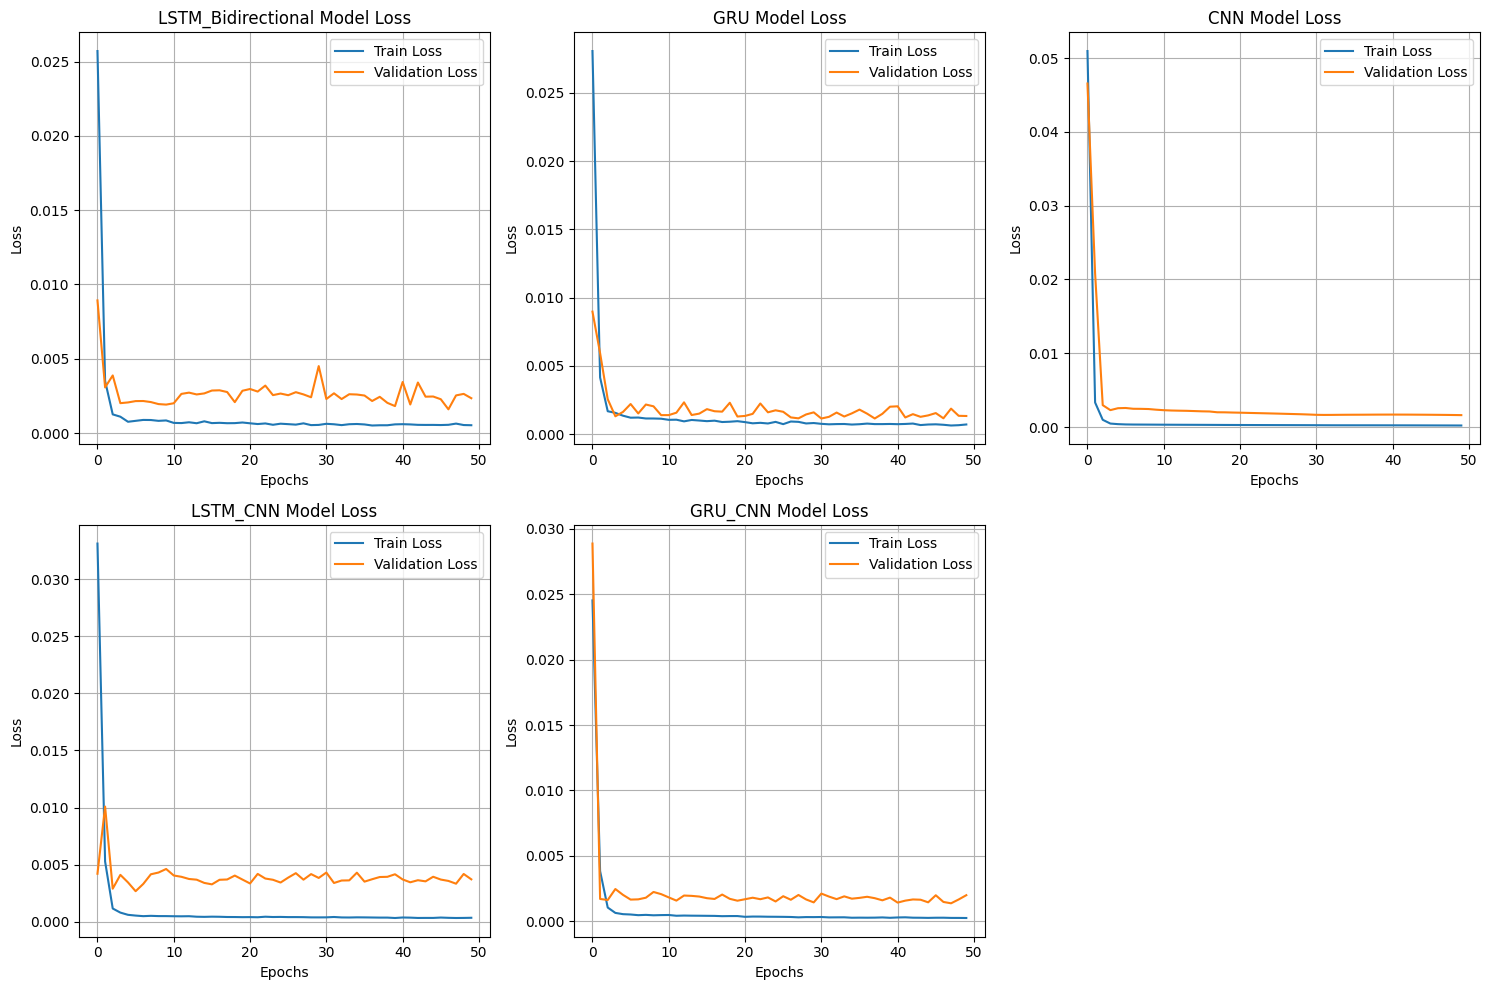

In [7]:
plt.figure(figsize=(15, 10))

for i, model_type in enumerate(model_types):
    plt.subplot(2, 3, i+1)
    plt.plot(histories[model_type].history['loss'], label='Train Loss')
    plt.plot(histories[model_type].history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


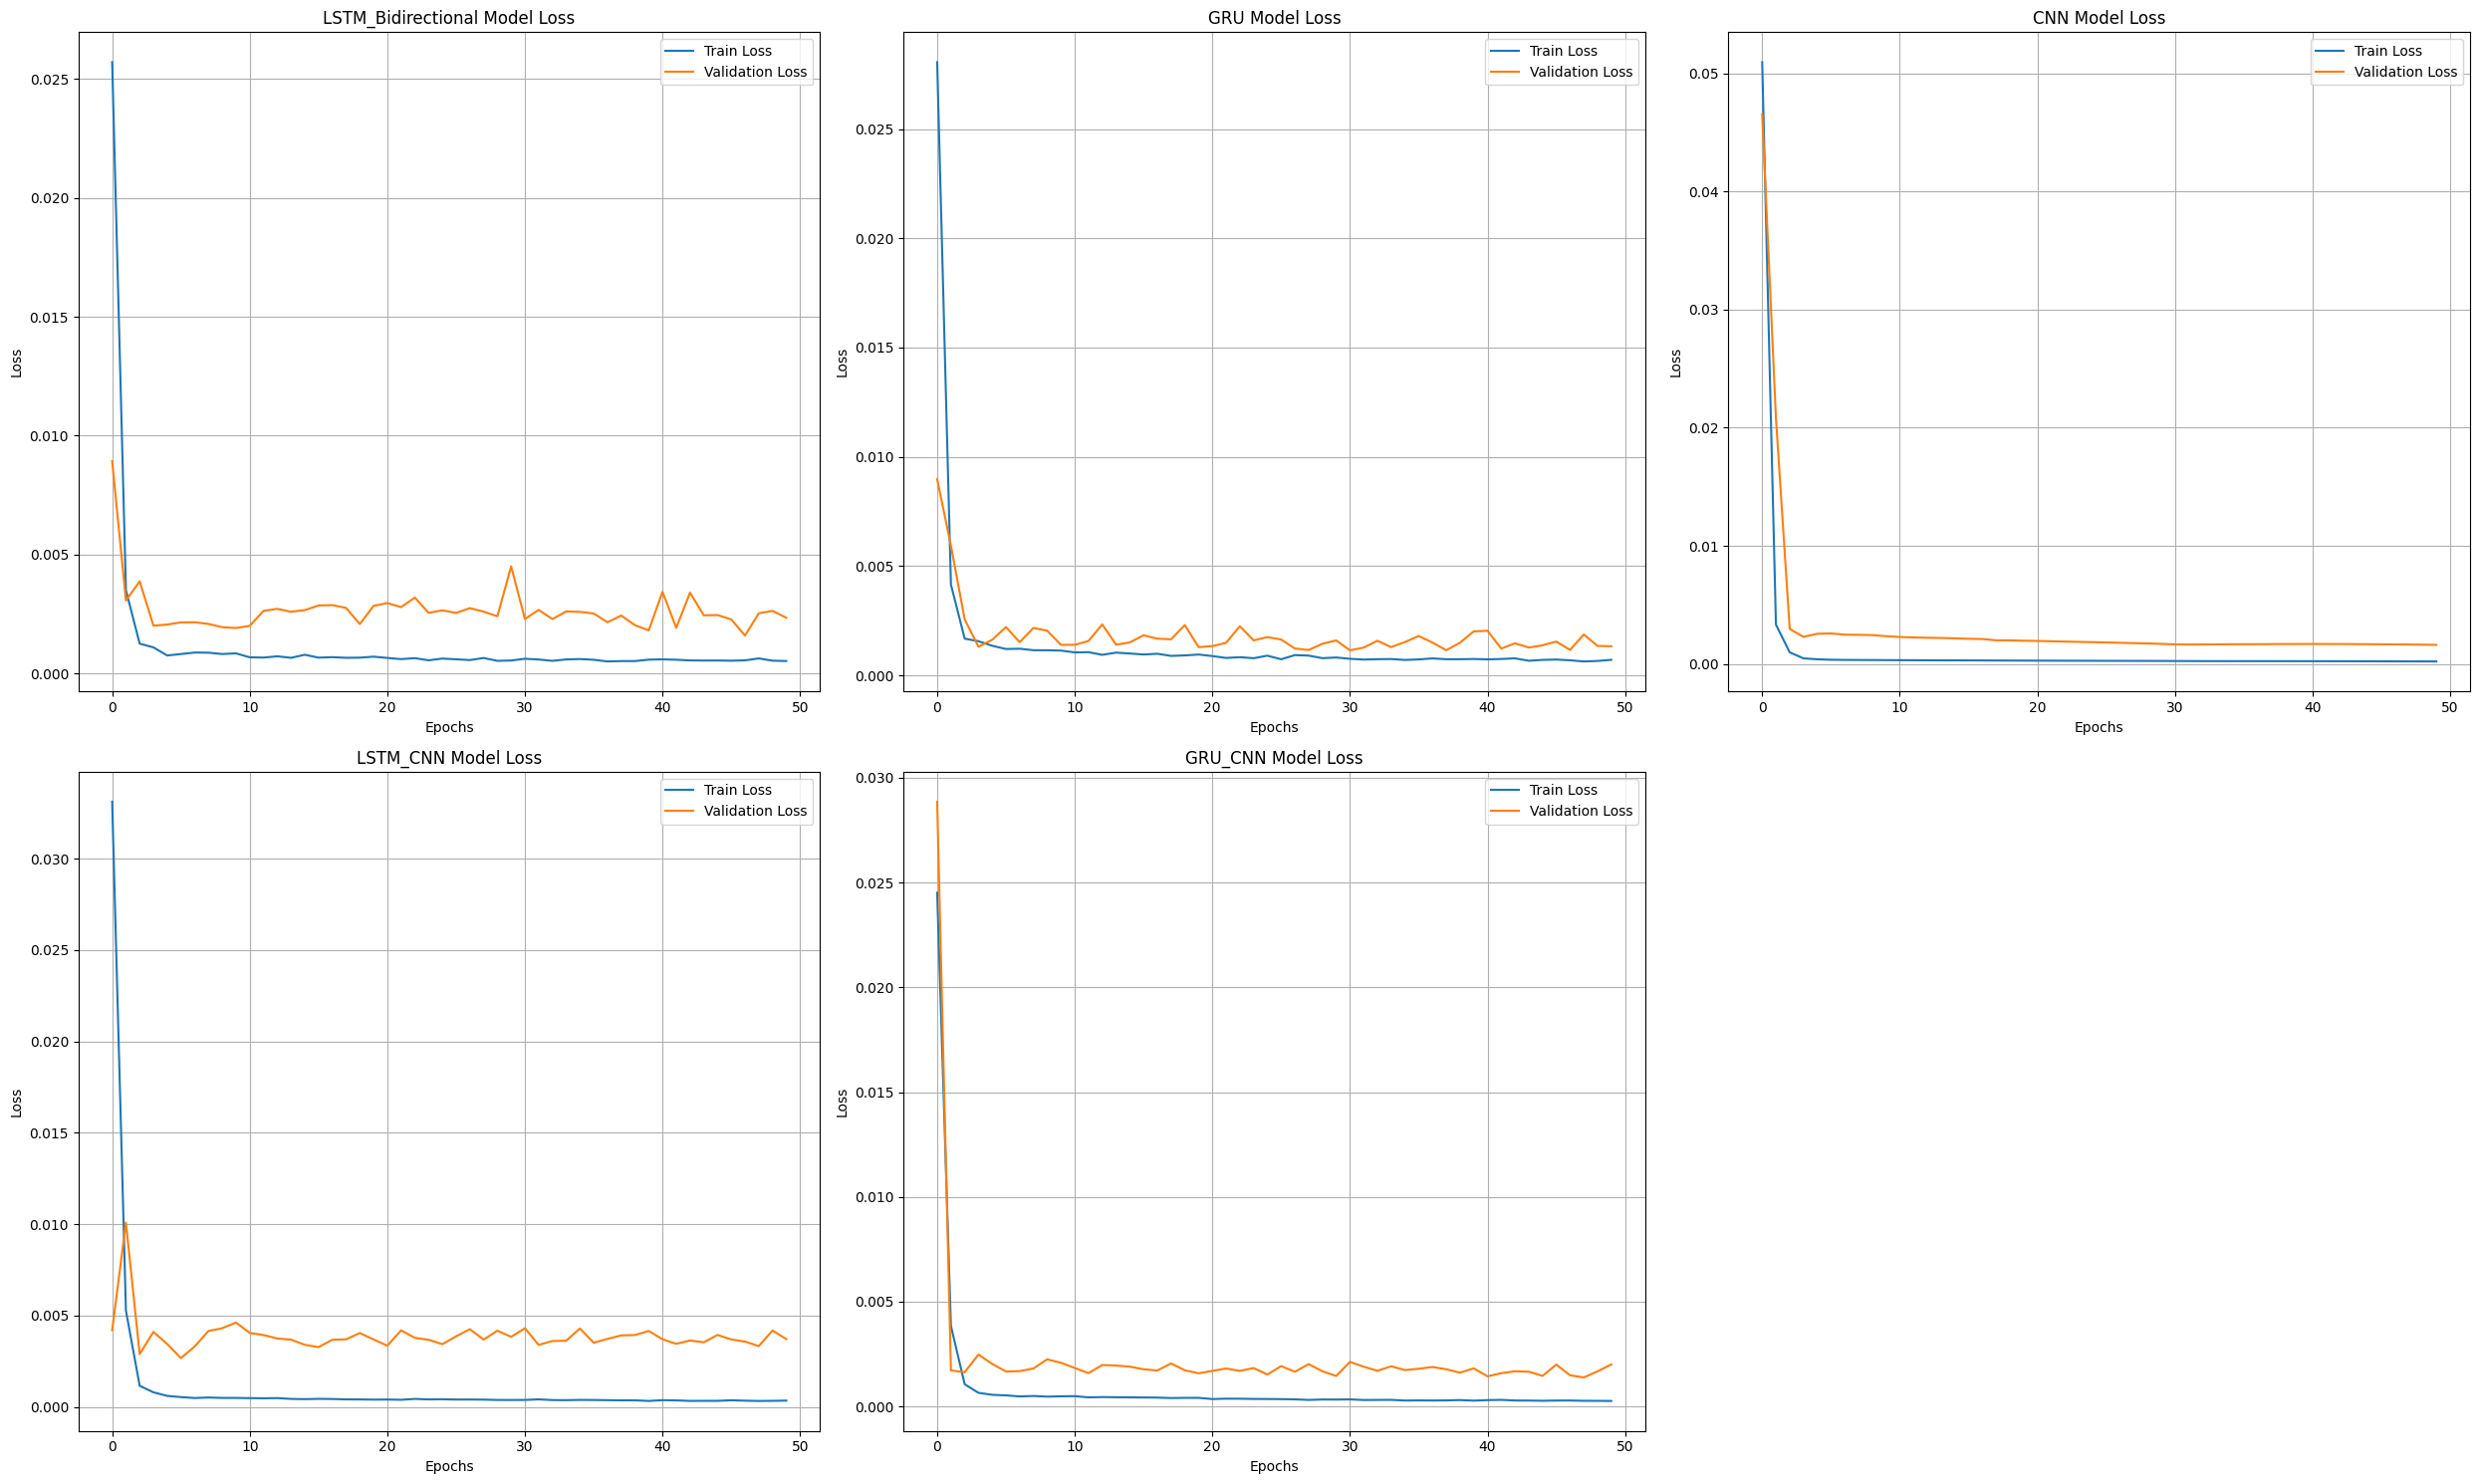

In [8]:
# Only dimensions are changed
plt.figure(figsize=(25, 15))

for i, model_type in enumerate(model_types):
    plt.subplot(2, 3, i+1)
    plt.plot(histories[model_type].history['loss'], label='Train Loss')
    plt.plot(histories[model_type].history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


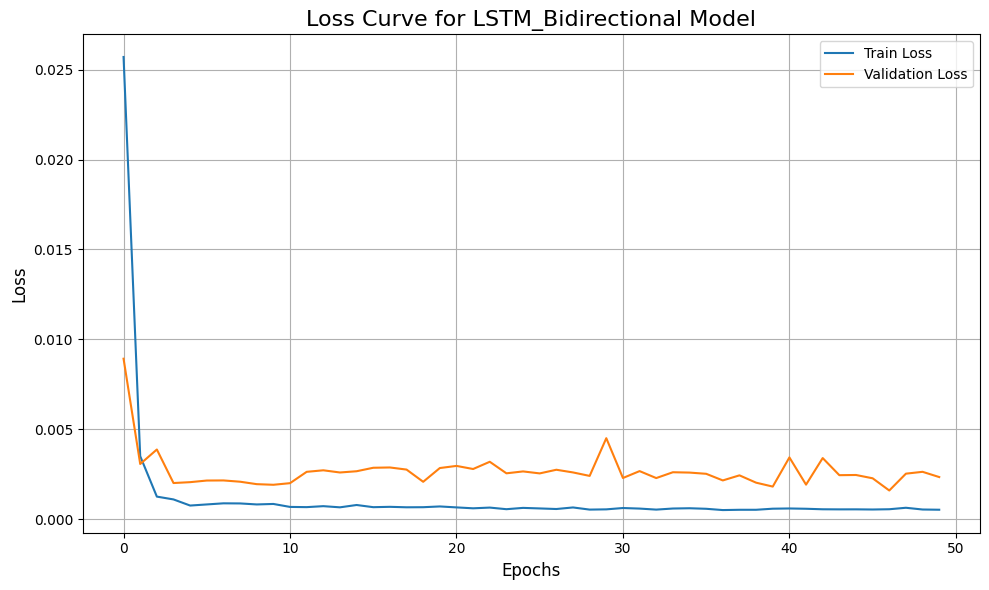

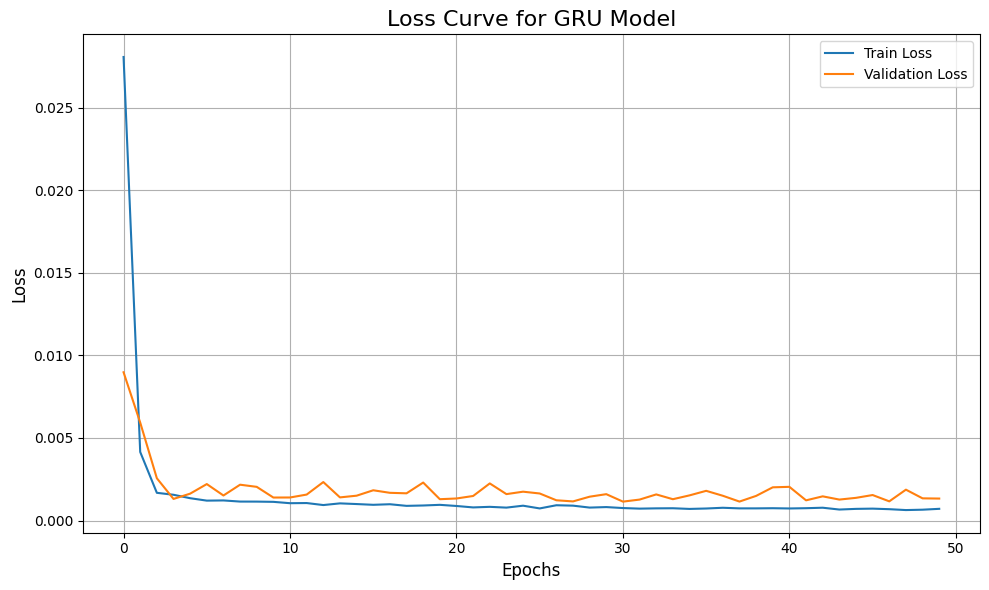

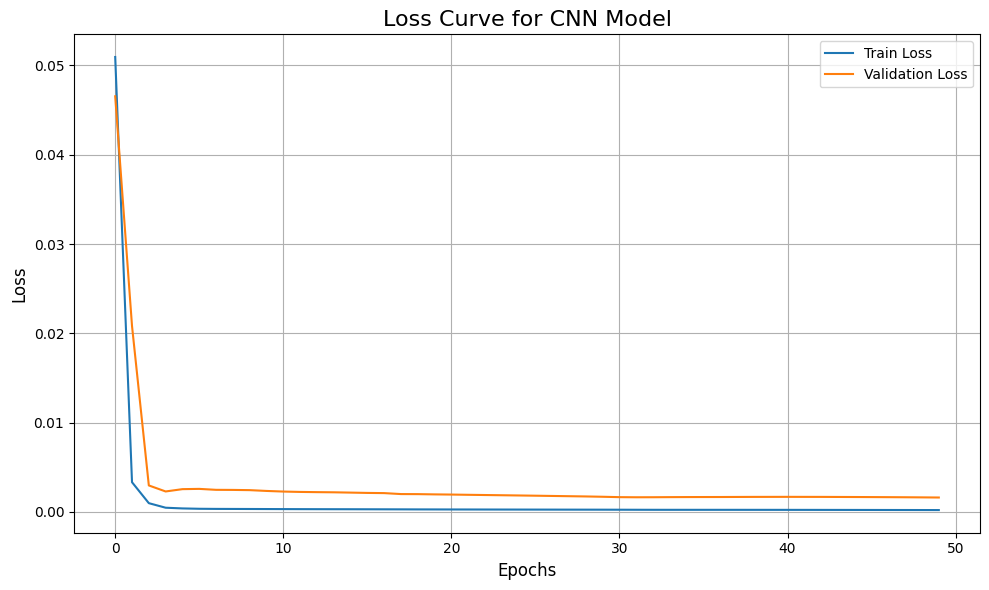

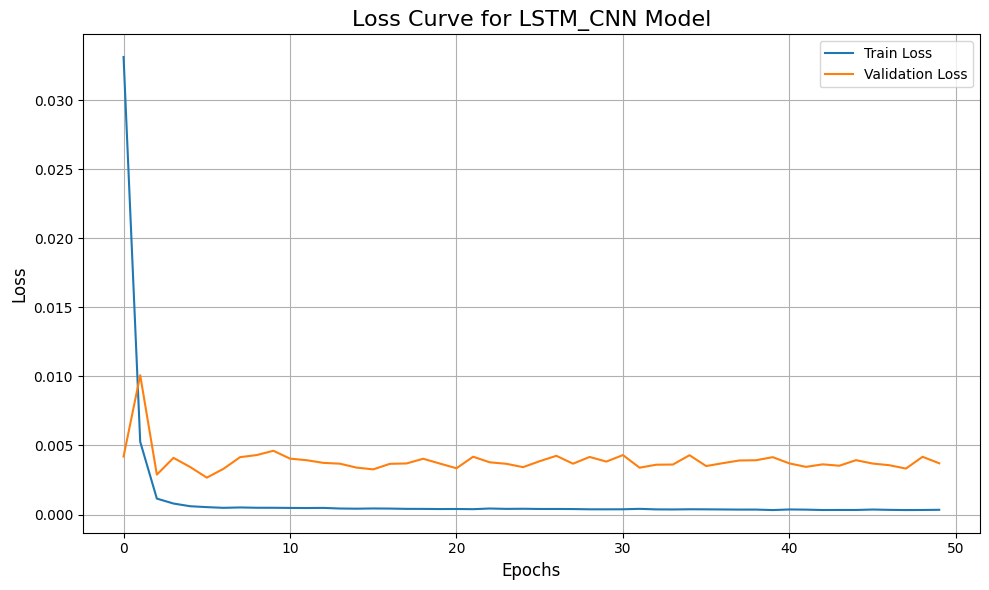

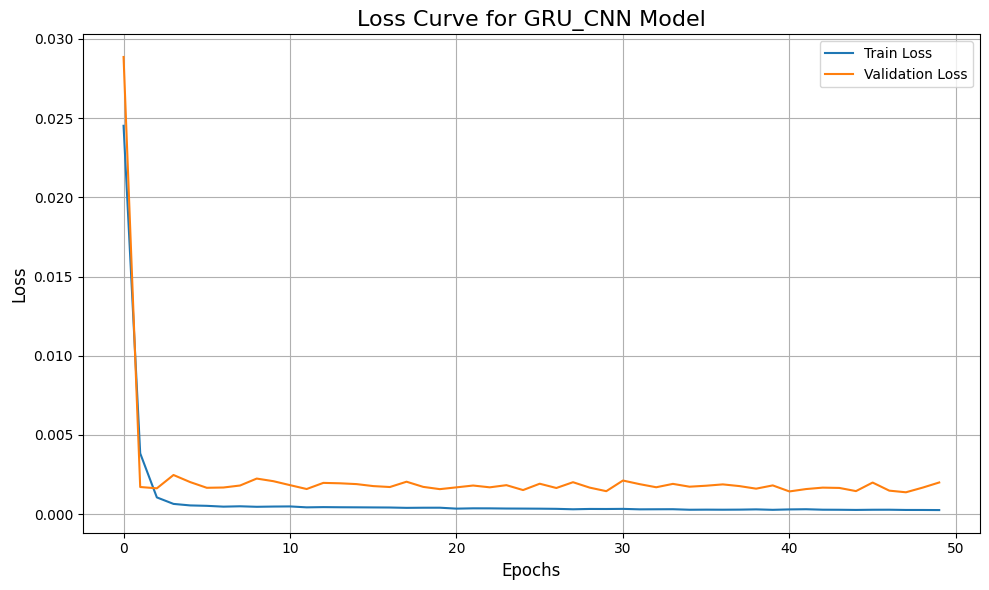

In [9]:
import matplotlib.pyplot as plt

for model_type in model_types:
    plt.figure(figsize=(10, 6))
    plt.plot(histories[model_type].history['loss'], label='Train Loss')
    plt.plot(histories[model_type].history['val_loss'], label='Validation Loss')

    plt.title(f'Loss Curve for {model_type} Model', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [10]:
# Generate predictions for all models
predictions = {}
for model_type in model_types:
    pred = models[model_type].predict(X_test)
    predictions[model_type] = scaler.inverse_transform(pred)

# Get the actual values
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Prepare ARIMA model
def train_arima_model(data, order=(5,1,0)):
    # Convert the data to a pandas Series
    ts = pd.Series(data.flatten())
    # Fit ARIMA model
    model = sm.tsa.ARIMA(ts, order=order)
    model_fit = model.fit()
    return model_fit

# Train ARIMA model on the training data
train_data = close_prices[:train_size]
arima_model = train_arima_model(train_data)

# Make predictions with ARIMA
arima_predictions = []
history = [x for x in train_data]
for t in range(len(X_test)):
    model = sm.tsa.ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    history.append(close_prices[train_size+t])

predictions['ARIMA'] = np.array(arima_predictions).reshape(-1, 1)

# Prepare FB Prophet model
def train_prophet_model(dates, values):
    # Create a dataframe for Prophet
    df = pd.DataFrame({'ds': dates, 'y': values.flatten()})
    # Initialize and fit the model
    model = Prophet()
    model.fit(df)
    return model

# Train Prophet model
train_dates = data.index[:train_size]
prophet_model = train_prophet_model(train_dates, close_prices[:train_size])

# Make predictions with Prophet
future = pd.DataFrame({'ds': data.index[train_size:train_size+len(X_test)]})
prophet_forecast = prophet_model.predict(future)
predictions['FB_Prophet'] = prophet_forecast['yhat'].values.reshape(-1, 1)



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc5k4nvlj/_ea_u8sm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc5k4nvlj/n9bftaol.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73677', 'data', 'file=/tmp/tmpc5k4nvlj/_ea_u8sm.json', 'init=/tmp/tmpc5k4nvlj/n9bftaol.json', 'output', 'file=/tmp/tmpc5k4nvlj/prophet_model50qq3lod/prophet_model-20250405100505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:05:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
# Calculate metrics for all models
metrics = {}
for model_type in predictions.keys():
    mae = mean_absolute_error(actual_prices, predictions[model_type])
    mse = mean_squared_error(actual_prices, predictions[model_type])
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_prices, predictions[model_type])

    metrics[model_type] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# Create a DataFrame for metrics comparison
metrics_df = pd.DataFrame(metrics).T
print("Performance Metrics Comparison:")
print(metrics_df)



Performance Metrics Comparison:
                           MAE           MSE        RMSE        R2
LSTM_Bidirectional   34.121510   1711.336565   41.368304  0.935237
GRU                  24.421066    971.639680   31.171135  0.963230
CNN                  27.550852   1179.553356   34.344626  0.955361
LSTM_CNN             44.015307   2711.598115   52.073008  0.897383
GRU_CNN              31.659344   1462.724952   38.245587  0.944645
ARIMA                53.097192   4622.993217   67.992597  0.825049
FB_Prophet          142.595409  26955.364999  164.180891 -0.020092


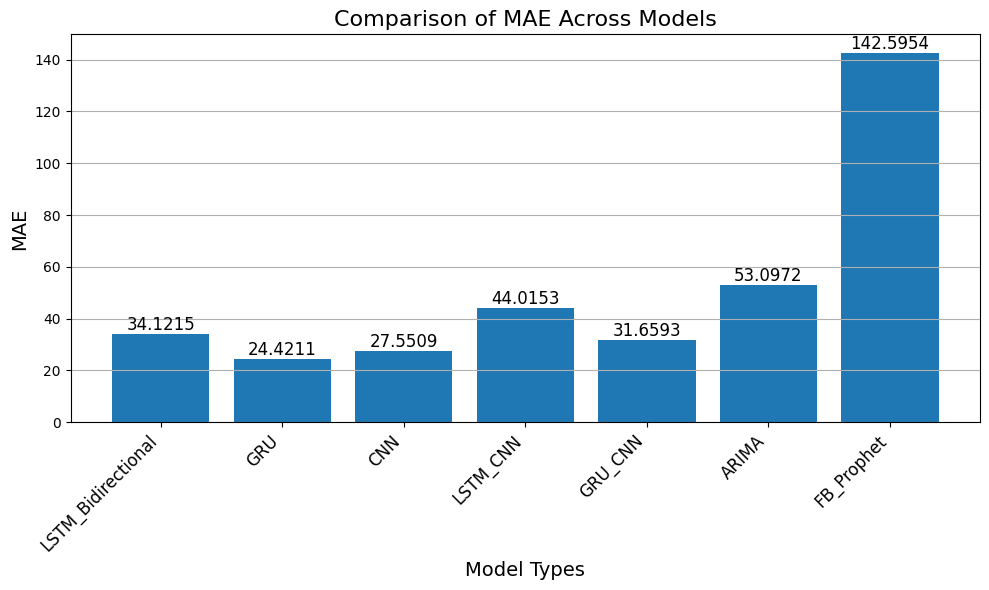

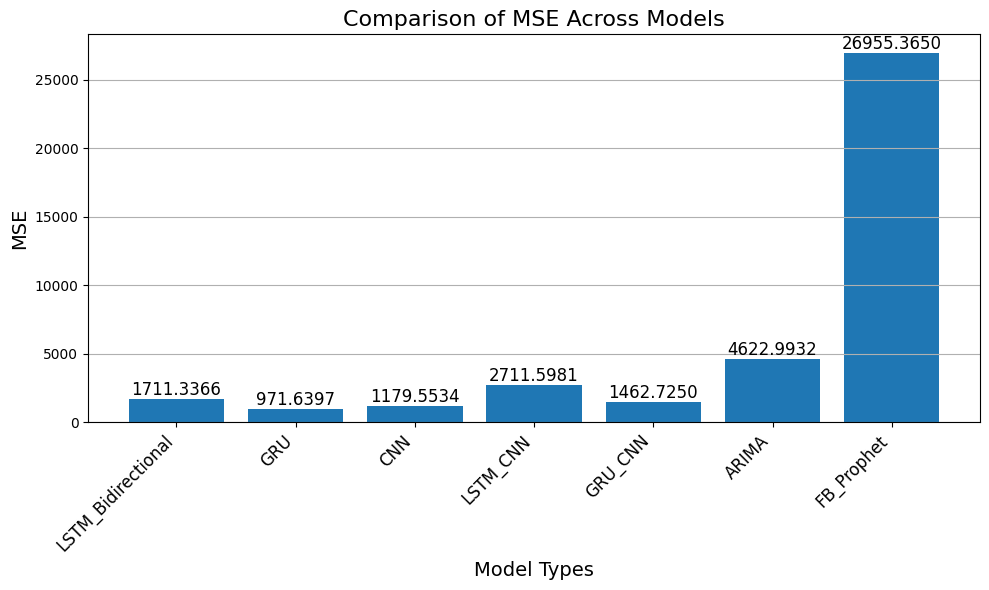

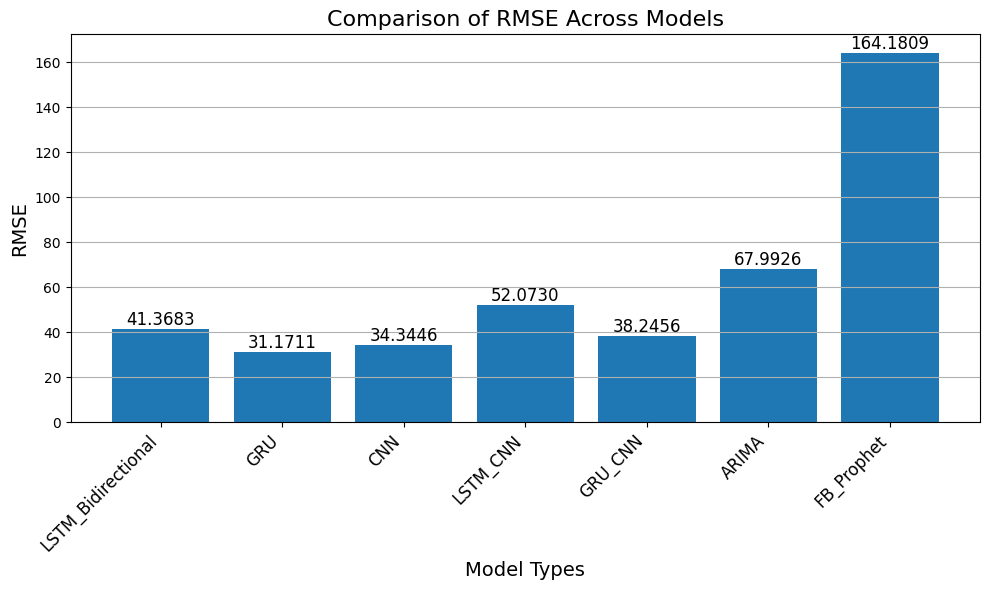

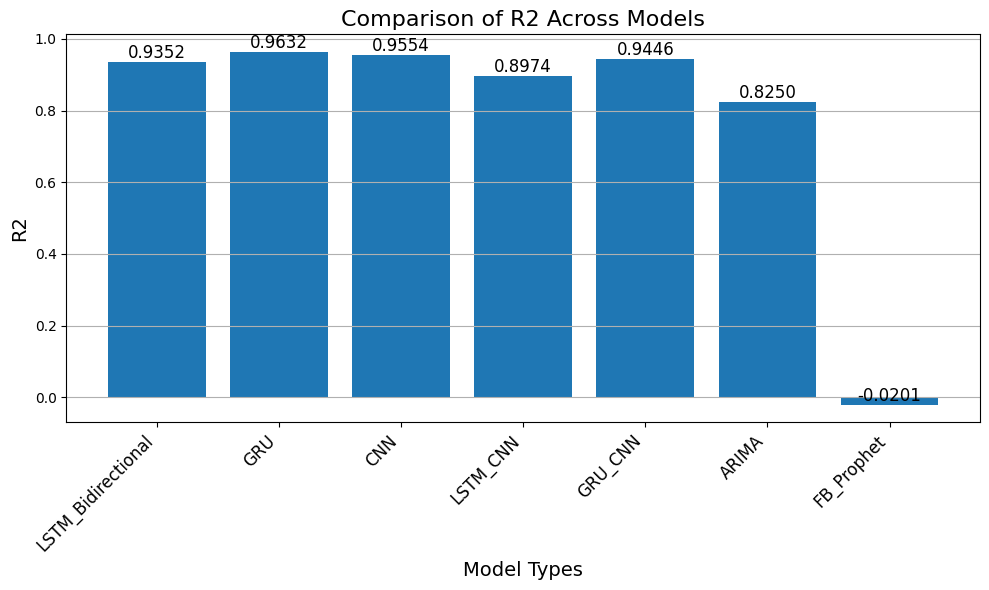

In [12]:
import matplotlib.pyplot as plt

metrics_to_plot = ['MAE', 'MSE', 'RMSE', 'R2']

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))

    plt.bar(metrics_df.index, metrics_df[metric])
    plt.title(f'Comparison of {metric} Across Models', fontsize=16)
    plt.xlabel('Model Types', fontsize=14)  # Increased from 12 to 14
    plt.ylabel(metric, fontsize=14)  # Increased from 12 to 14
    plt.xticks(rotation=45, ha='right', fontsize=12)  # Added fontsize parameter
    plt.grid(True, axis='y')

    # Add value labels on top of each bar with increased font size
    for i, v in enumerate(metrics_df[metric]):
        plt.text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=12)  # Added fontsize parameter

    plt.tight_layout()
    plt.show()


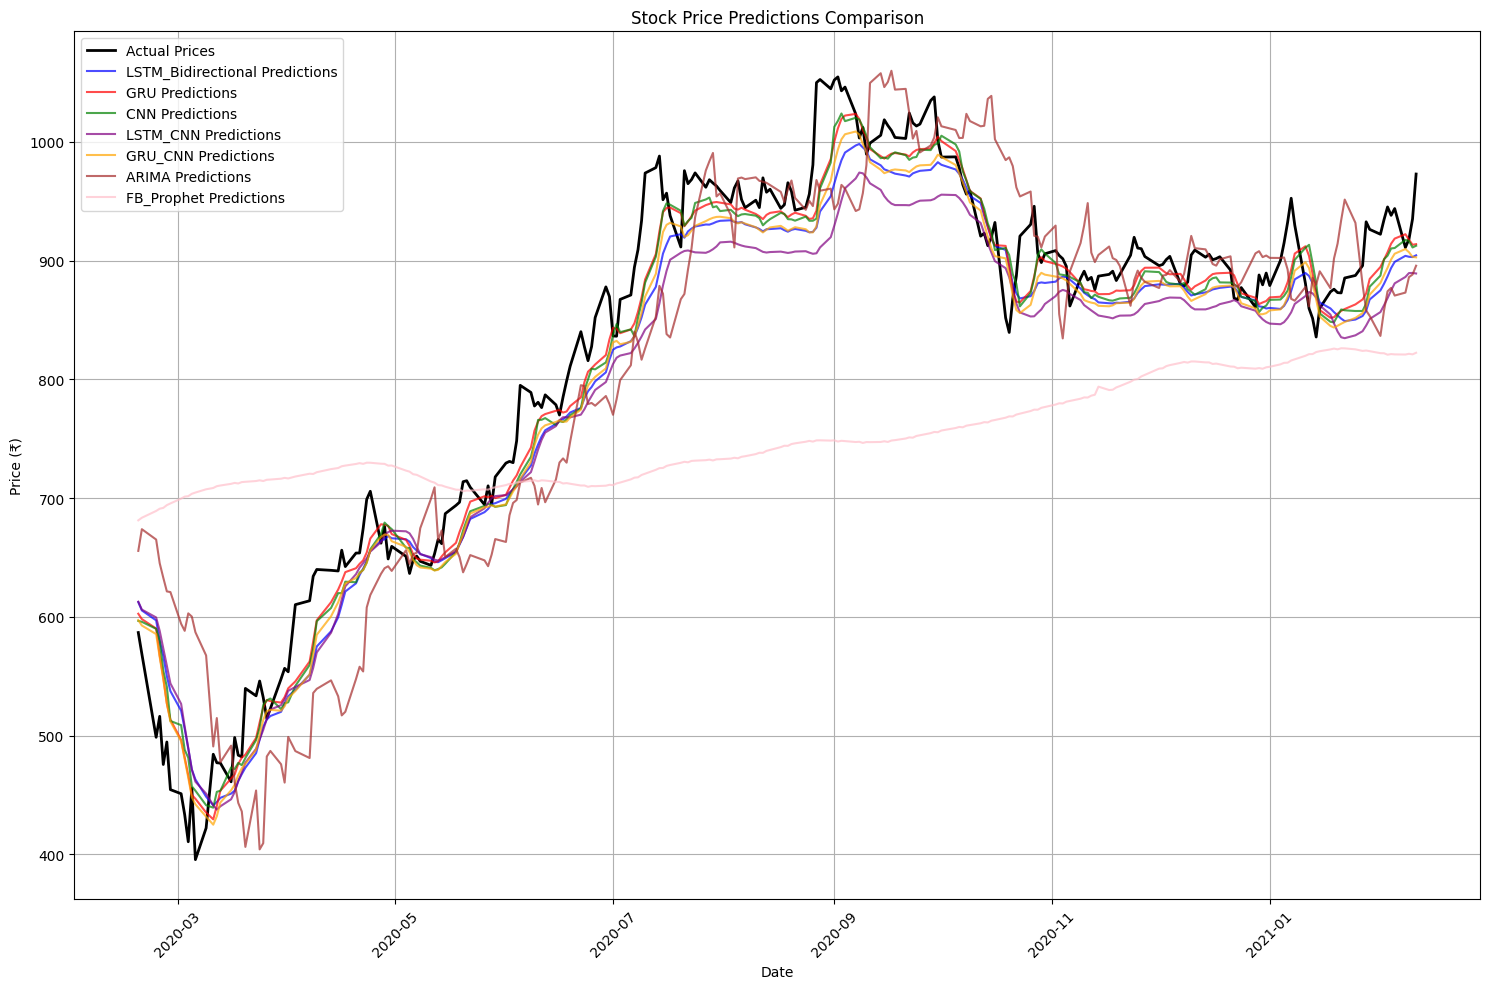

In [13]:
# Plot predictions vs actual values
plt.figure(figsize=(15, 10))

# Get test dates for plotting
test_dates = data.index[train_size:train_size+len(X_test)]

# Plot actual prices
plt.plot(test_dates, actual_prices, label='Actual Prices', color='black', linewidth=2)

# Plot predictions for each model with different colors
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']
for i, (model_type, pred) in enumerate(predictions.items()):
    plt.plot(test_dates, pred, label=f'{model_type} Predictions', color=colors[i], alpha=0.7)

plt.title('Stock Price Predictions Comparison')
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



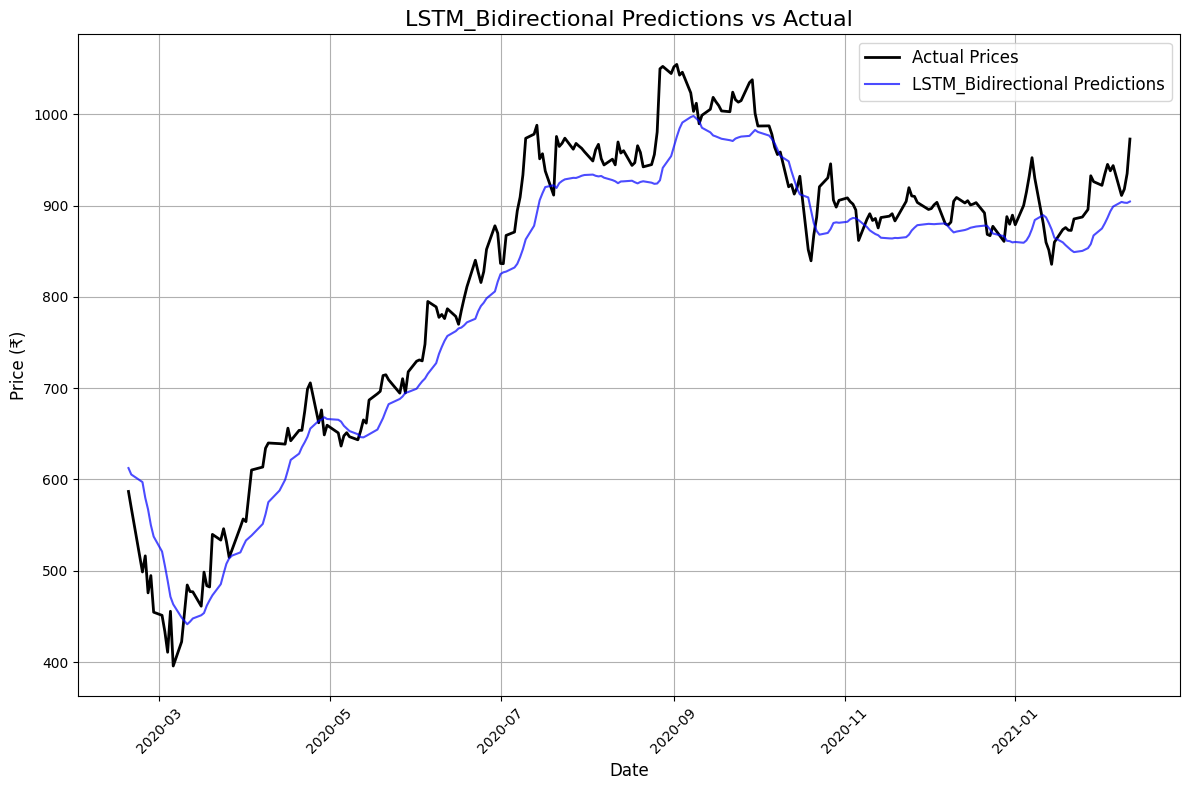

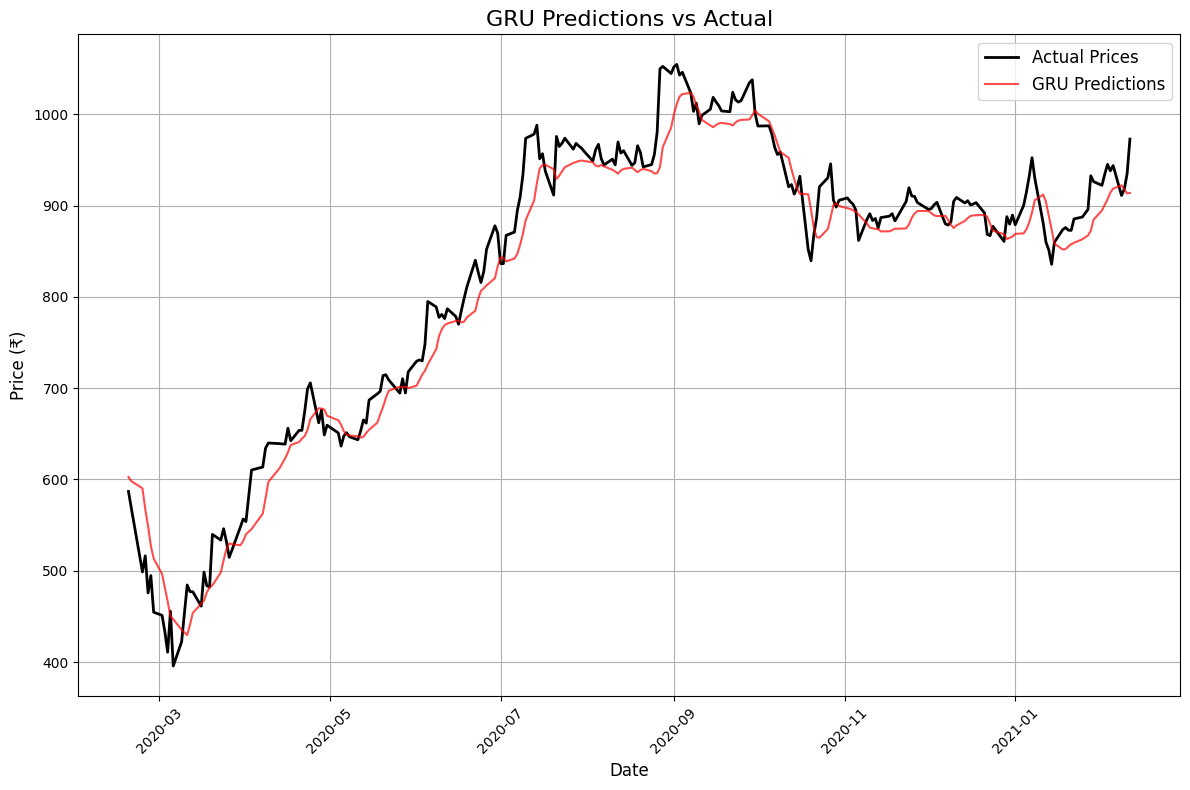

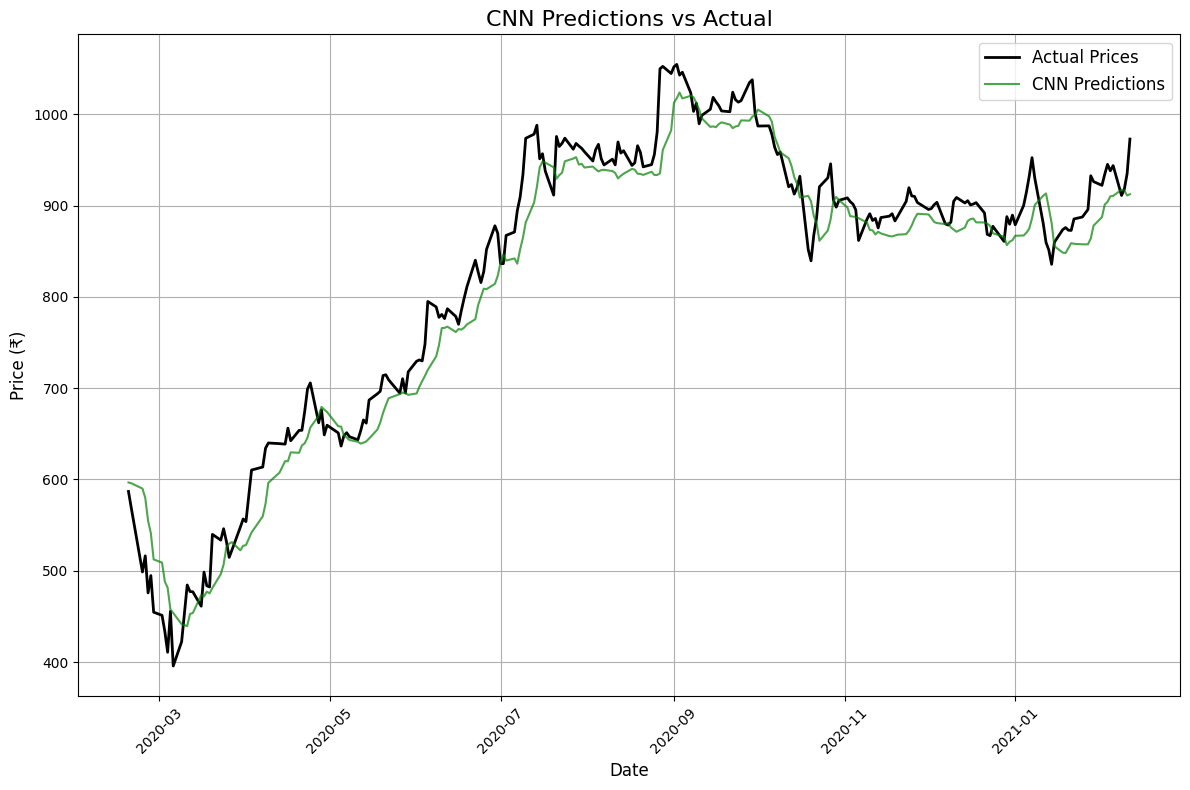

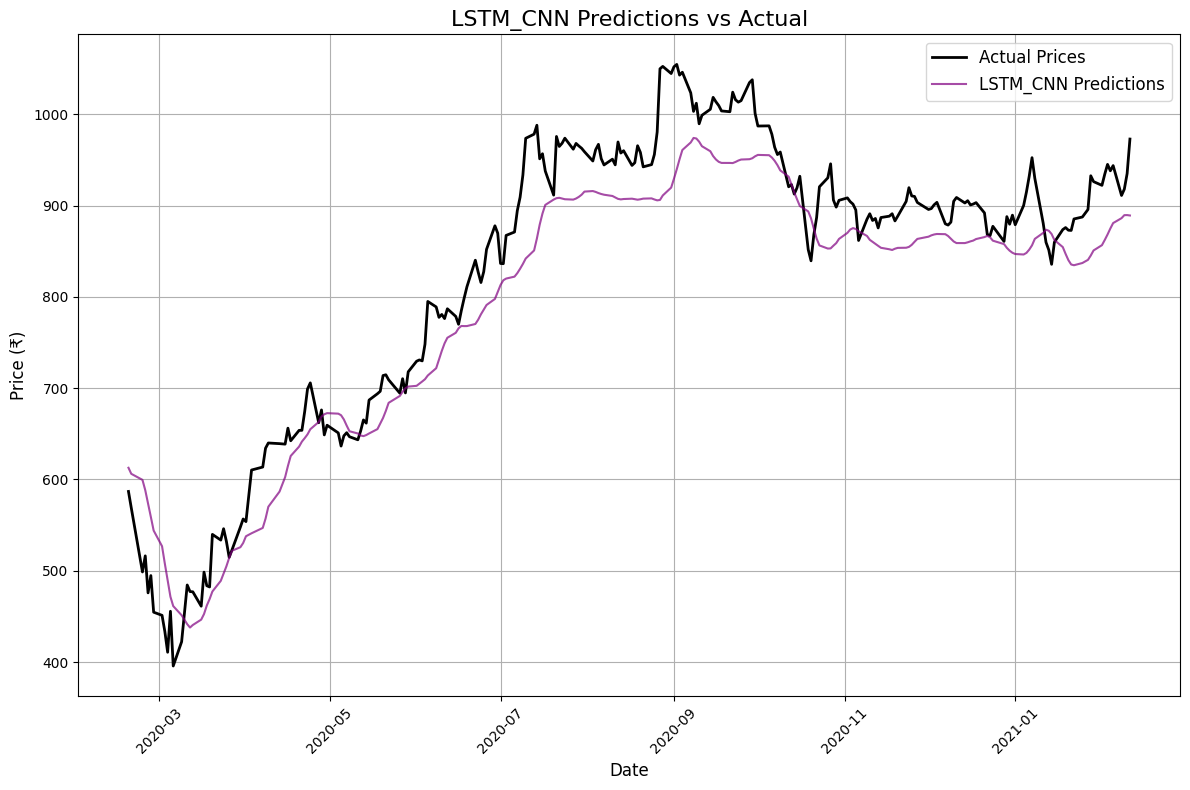

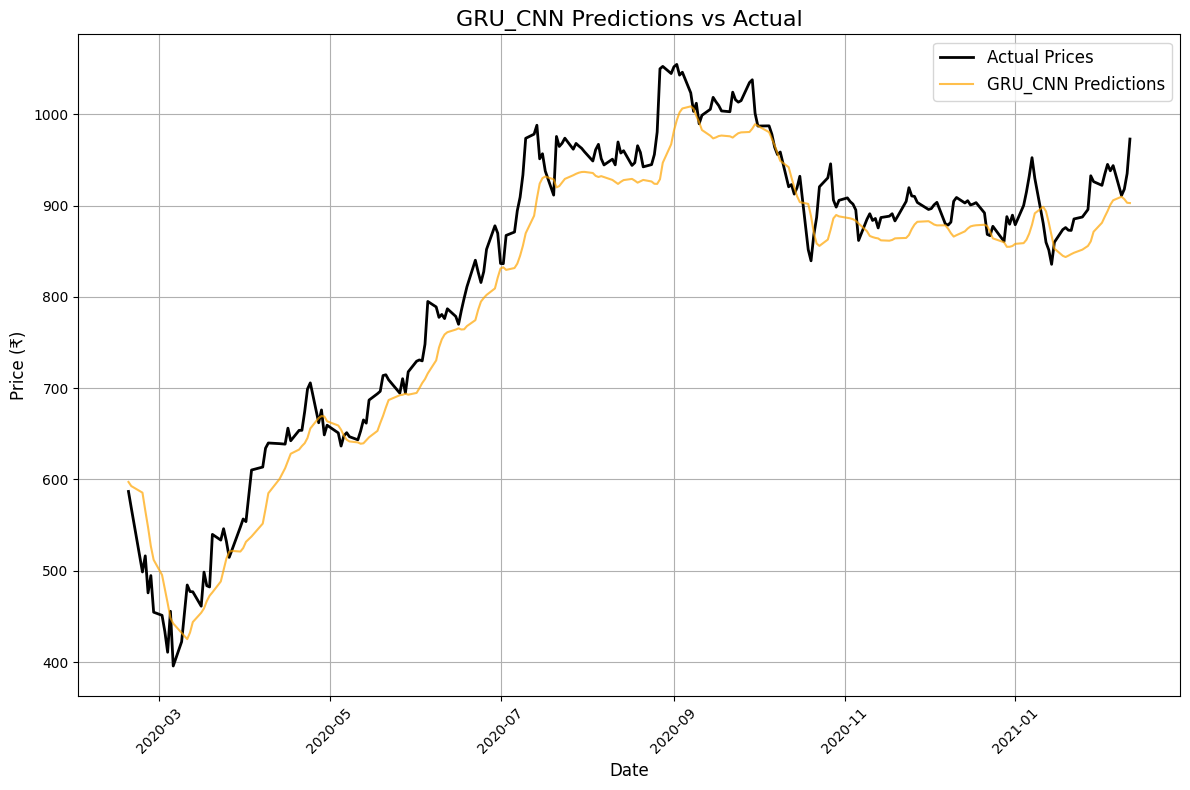

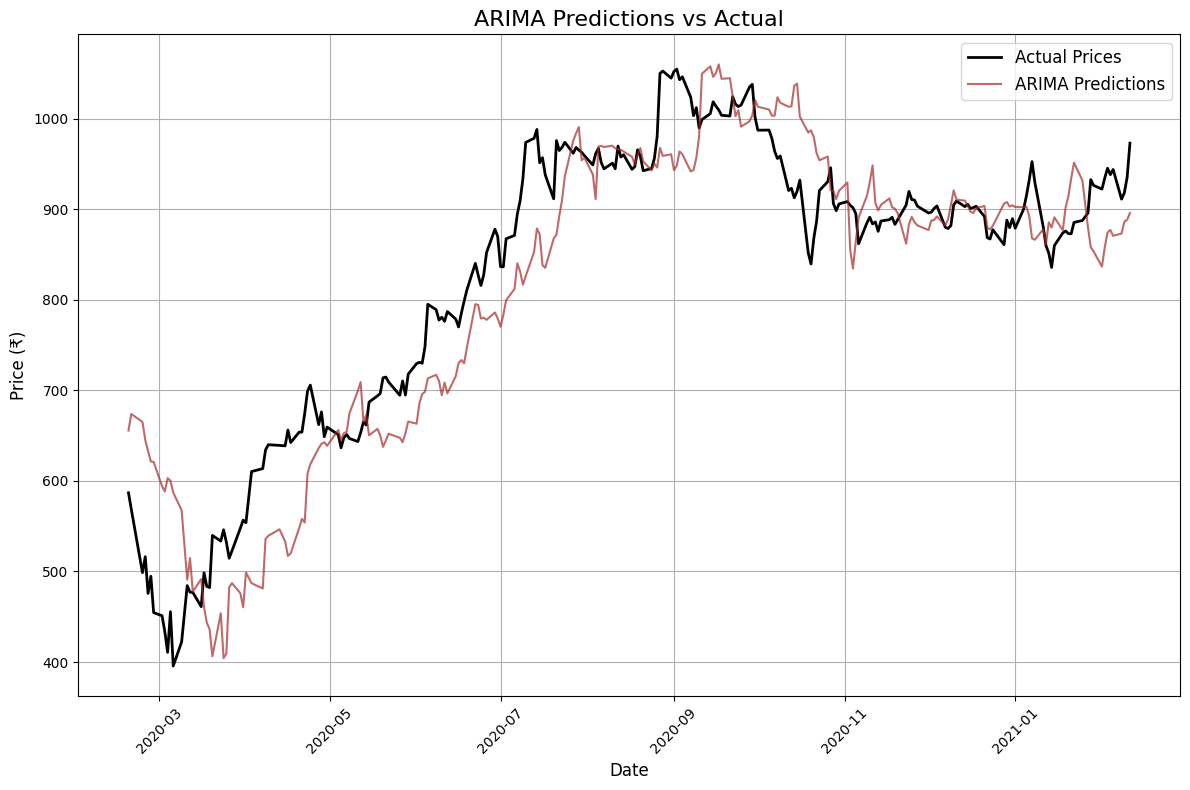

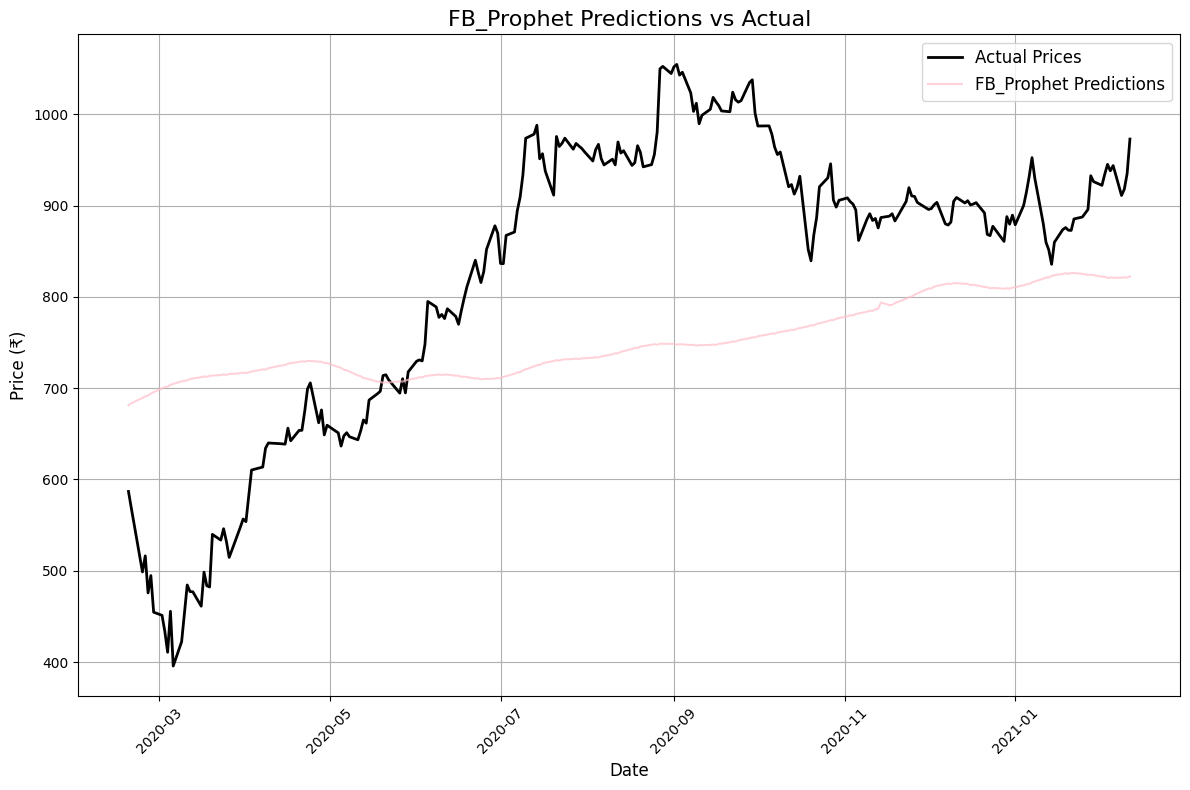

In [14]:
# Plot individual model predictions one by one
for i, model_type in enumerate(predictions.keys()):
    # Create a new figure for each model
    plt.figure(figsize=(12, 8))

    # Plot actual prices vs predictions
    plt.plot(test_dates, actual_prices, label='Actual Prices', color='black', linewidth=2)
    plt.plot(test_dates, predictions[model_type], label=f'{model_type} Predictions', color=colors[i], alpha=0.7)

    # Set title and labels
    plt.title(f'{model_type} Predictions vs Actual', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (₹)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

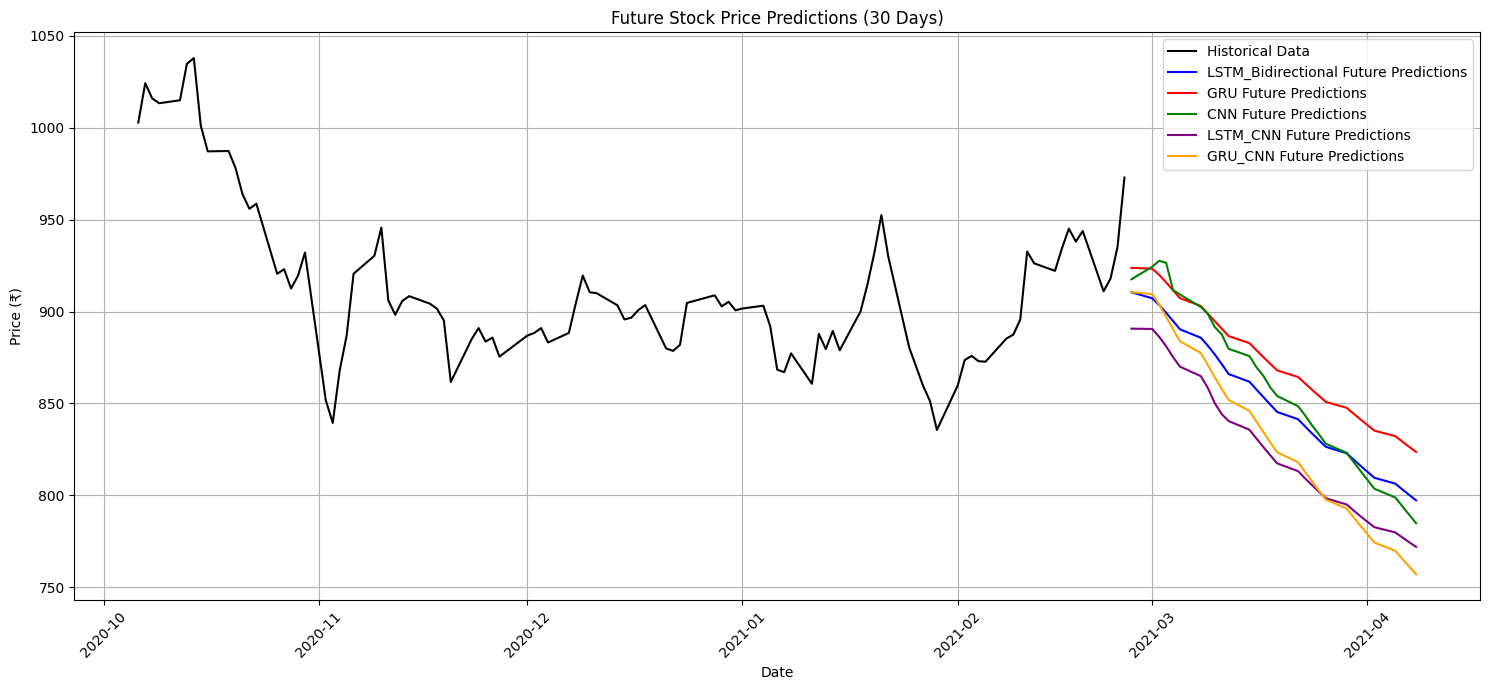

In [15]:
# Generate future predictions for the next 30 days
def generate_future_predictions(model, last_sequence, n_steps=30):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        # Reshape for prediction
        current_sequence_reshaped = current_sequence.reshape(1, window_size, 1)
        # Get prediction (scaled)
        next_pred = model.predict(current_sequence_reshaped)[0, 0]
        # Add to predictions
        future_predictions.append(next_pred)
        # Update sequence
        current_sequence = np.append(current_sequence[1:], next_pred)

    # Convert scaled predictions back to original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions

# Get the last sequence from our data
last_sequence = scaled_data[-window_size:]

# Generate future predictions for each deep learning model
future_predictions = {}
for model_type in model_types:
    future_pred = generate_future_predictions(models[model_type], last_sequence.flatten())
    future_predictions[model_type] = future_pred

# Generate dates for future predictions
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')

# Plot future predictions
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(data.index[-100:], data['Close'].values[-100:], label='Historical Data', color='black')

# Plot future predictions for each model
for i, (model_type, pred) in enumerate(future_predictions.items()):
    plt.plot(future_dates, pred, label=f'{model_type} Future Predictions', color=colors[i])

plt.title('Future Stock Price Predictions (30 Days)')
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Model Performance Summary (Ranked by RMSE):
                Model         MAE           MSE        RMSE        R2
1                 GRU   24.421066    971.639680   31.171135  0.963230
2                 CNN   27.550852   1179.553356   34.344626  0.955361
4             GRU_CNN   31.659344   1462.724952   38.245587  0.944645
0  LSTM_Bidirectional   34.121510   1711.336565   41.368304  0.935237
3            LSTM_CNN   44.015307   2711.598115   52.073008  0.897383
5               ARIMA   53.097192   4622.993217   67.992597  0.825049
6          FB_Prophet  142.595409  26955.364999  164.180891 -0.020092

Best performing model: GRU


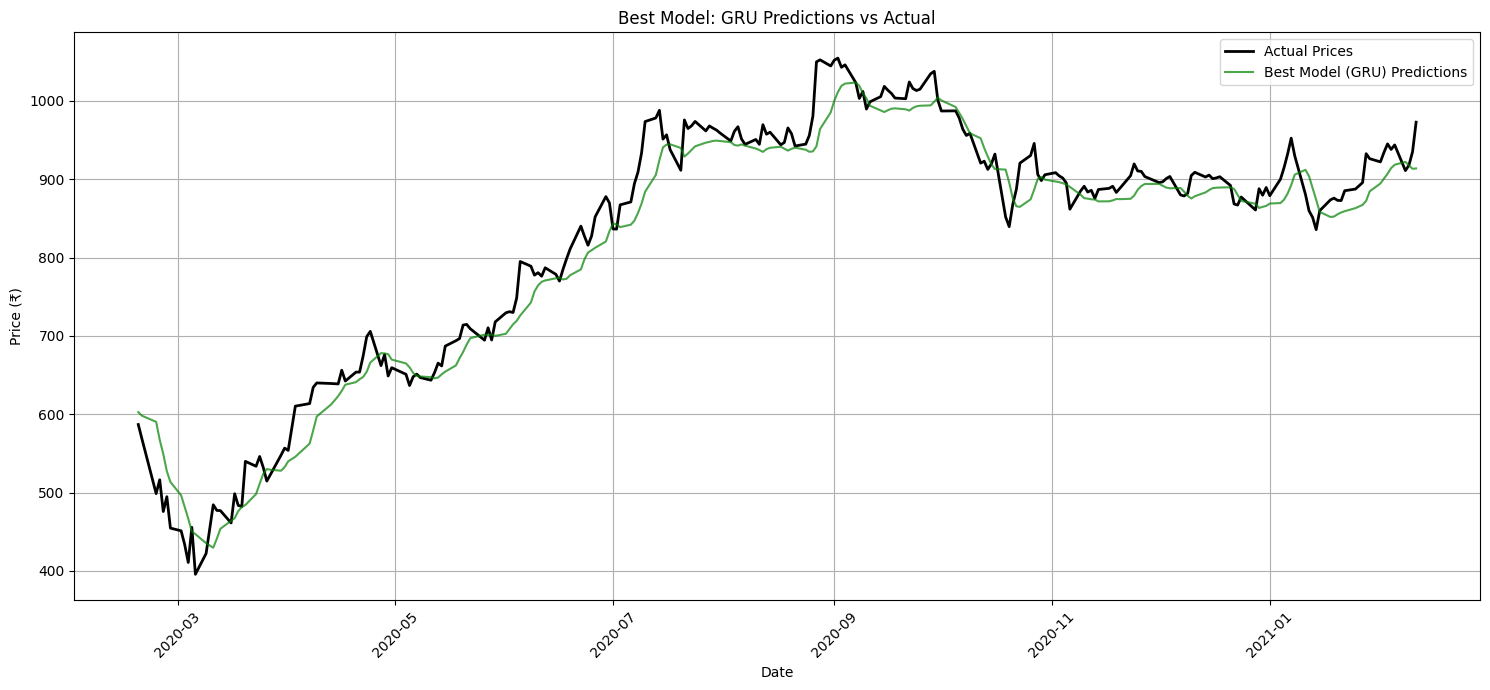

In [16]:
# Create a summary table of all models
summary_data = {
    'Model': list(metrics_df.index),
    'MAE': [metrics_df.loc[model, 'MAE'] for model in metrics_df.index],
    'MSE': [metrics_df.loc[model, 'MSE'] for model in metrics_df.index],
    'RMSE': [metrics_df.loc[model, 'RMSE'] for model in metrics_df.index],
    'R2': [metrics_df.loc[model, 'R2'] for model in metrics_df.index]
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('RMSE')  # Sort by RMSE (lower is better)

print("Model Performance Summary (Ranked by RMSE):")
print(summary_df)

# Visualize the best performing model
best_model = summary_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model}")

plt.figure(figsize=(15, 7))
plt.plot(test_dates, actual_prices, label='Actual Prices', color='black', linewidth=2)
plt.plot(test_dates, predictions[best_model], label=f'Best Model ({best_model}) Predictions', color='green', alpha=0.7)
plt.title(f'Best Model: {best_model} Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
